### Основные определения

**Предобработка данных (Data Preprocessing)** — преобразование "сырых" данных в формат, пригодный для машинного обучения. Включает обработку пропусков, масштабирование, кодирование категорий, feature engineering.

**Нормализация (Normalization)** — масштабирование признаков к диапазону [0, 1]. Формула: `x_norm = (x - x_min) / (x_max - x_min)`. Используется в алгоритмах, чувствительных к масштабу (kNN, SVM, нейронные сети).

**Стандартизация (Standardization)** — преобразование признаков к распределению с mean=0, std=1. Формула: `x_std = (x - mean) / std`. Робустнее к выбросам, чем нормализация. Часто предпочтительнее для линейных моделей.

**Data Leakage (Утечка данных)** — ситуация, когда информация из тестовой выборки "просачивается" в обучающую, завышая оценки качества модели. Пример: вычислить среднее по всему датасету, затем разделить на train/test — тест "видел" среднее из train.

**Pipeline** — объект в sklearn, объединяющий несколько шагов предобработки и обучения в один вызов. Гарантирует правильный порядок операций и предотвращает data leakage.

**Imputation (Импутация)** — заполнение пропущенных значений. Стратегии: удаление строк/столбцов, заполнение константой (0, median, mode), kNN-импутация, модельная импутация (предсказание пропуска).

**One-Hot Encoding** — преобразование категориального признака в набор бинарных (0/1) признаков. Пример: "цвет" = {красный, синий, зелёный} → 3 столбца: color_red, color_blue, color_green.

**Label Encoding** — преобразование категорий в числа 0, 1, 2, ... Опасность: модель может интерпретировать как упорядоченные (2 > 1 > 0), что неверно для номинальных категорий.

###  Ключевые пакеты

# Основные библиотеки
import pandas as pd              # Работа с табличными данными

import numpy as np               # Численные операции

import matplotlib.pyplot as plt  # Визуализация

import seaborn as sns            # Продвинутая визуализация

# Sklearn: предобработка
from sklearn.preprocessing import (

    StandardScaler,    # Стандартизация (mean=0, std=1)

    MinMaxScaler,      # Нормализация [0, 1]
    
    RobustScaler,      # Масштабирование с учётом выбросов (median, IQR)
    
    LabelEncoder,      # Кодирование категорий в числа
    
    OneHotEncoder      # One-hot encoding категорий
)

from sklearn.impute import SimpleImputer  # Простая импутация (mean, median, mode)

# Sklearn: Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.compose import ColumnTransformer  # Разная обработка для разных столбцов

# Sklearn: модели и метрики
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.1)

# Загрузка Titanic
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

print(f"Датасет Titanic: {df.shape[0]} строк × {df.shape[1]} столбцов")
print("Целевая переменная: Survived (0 = погиб, 1 = выжил)")

Датасет Titanic: 891 строк × 12 столбцов
Целевая переменная: Survived (0 = погиб, 1 = выжил)


Датасет Titanic из репозитория Data Science Dojo содержит информацию о пассажирах корабля "Титаник". Это классический набор данных для задач машинного обучения по предсказанию выживания.

Основные характеристики
Размер: около 891 строки (тренировочная выборка) и 12 столбцов.

Целевая переменная: Survived (0 — не выжил, 1 — выжил).

Ключевые столбцы
PassengerId: уникальный ID пассажира.

Pclass: класс билета (1, 2, 3).

Name, Sex, Age: имя, пол, возраст (много пропусков в Age).

SibSp, Parch: количество сиблингов/супругов и родителей/детей на борту.

Ticket, Fare, Cabin: номер билета, цена, каюта (много пропусков в Cabin).

Embarked: порт посадки (C, Q, S).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

=== ПРОБЛЕМА 1: ПРОПУСКИ ===
  Признак  Пропусков  Процент
    Cabin        687     77.1
      Age        177     19.9
 Embarked          2      0.2


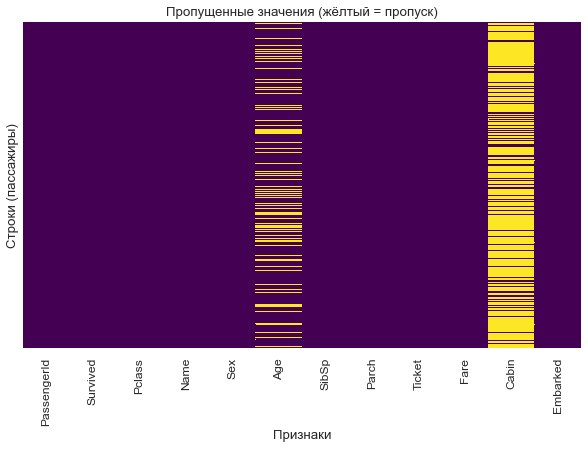

In [30]:
df.head(10)
df.info()

# ПРОБЛЕМА 1: Пропущенные значения
print("\n=== ПРОБЛЕМА 1: ПРОПУСКИ ===")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_df = pd.DataFrame({
    'Признак': missing.index,
    'Пропусков': missing.values,
    'Процент': missing_pct.values
})
missing_df = missing_df[missing_df['Пропусков'] > 0].sort_values('Пропусков', ascending=False)
print(missing_df.to_string(index=False))

# Визуализация пропусков
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Пропущенные значения (жёлтый = пропуск)')
plt.xlabel('Признаки')
plt.ylabel('Строки (пассажиры)')
plt.show()


=== ПРОБЛЕМА 2: КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ ===
Категориальные признаки (5): ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

Name: 891 уникальных значений
Ahlin, Mrs. Johan (Johanna Persdotter Larsson)    1
Moutal, Mr. Rahamin Haim                          1
Coleff, Mr. Peju                                  1
Shelley, Mrs. William (Imanita Parrish Hall)      1
Smith, Mr. James Clinch                           1
Name: Name, dtype: int64

Sex: 2 уникальных значений
male      577
female    314
Name: Sex, dtype: int64

Ticket: 681 уникальных значений
CA. 2343    7
347082      7
1601        7
CA 2144     6
347088      6
Name: Ticket, dtype: int64

Cabin: 147 уникальных значений
C23 C25 C27    4
B96 B98        4
G6             4
F2             3
E101           3
Name: Cabin, dtype: int64

Embarked: 3 уникальных значений
S    644
C    168
Q     77
Name: Embarked, dtype: int64

=== ПРОБЛЕМА 3: РАЗНЫЕ МАСШТАБЫ ===
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count

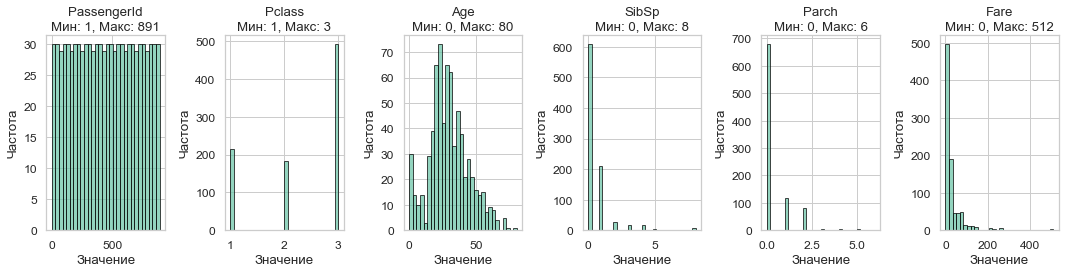

In [31]:
# ПРОБЛЕМА 2: Категориальные признаки
print("\n=== ПРОБЛЕМА 2: КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ ===")
categorical = df.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки ({len(categorical)}): {categorical}")
for col in categorical:
    print(f"\n{col}: {df[col].nunique()} уникальных значений")
    print(df[col].value_counts().head())

# ПРОБЛЕМА 3: Разные масштабы числовых признаков
print("\n=== ПРОБЛЕМА 3: РАЗНЫЕ МАСШТАБЫ ===")
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
numeric.remove('Survived')  # Убираем целевую переменную
print(df[numeric].describe())

# Визуализация масштабов
fig, axes = plt.subplots(1, len(numeric), figsize=(15, 4))
for i, col in enumerate(numeric):
    axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{col}\nМин: {df[col].min():.0f}, Макс: {df[col].max():.0f}')
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')
plt.tight_layout()
plt.show()

In [32]:
# Сколько строк потеряем?
df_complete = df.dropna()
print(f"Исходный датасет: {len(df)} строк")
print(f"После удаления пропусков: {len(df_complete)} строк")
print(f"Потеряно: {len(df) - len(df_complete)} строк ({(1 - len(df_complete)/len(df))*100:.1f}%)")



Исходный датасет: 891 строк
После удаления пропусков: 183 строк
Потеряно: 708 строк (79.5%)


In [33]:
# Удалим столбцы с >50% пропусков
threshold = 0.5
cols_to_drop = missing_df[missing_df['Процент'] > threshold * 100]['Признак'].tolist()
print(f"Столбцы с >{threshold*100}% пропусков: {cols_to_drop}")
print("Cabin (77% пропусков) — разумно удалить, там мало информации")

Столбцы с >50.0% пропусков: ['Cabin']
Cabin (77% пропусков) — разумно удалить, там мало информации


После заполнения:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


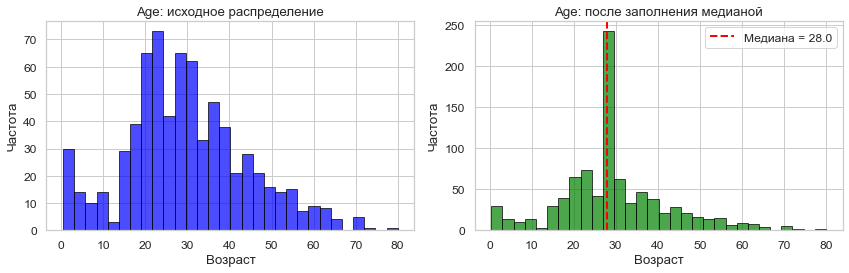

In [34]:
# Создаём копию для экспериментов
df_filled = df.copy()

# Age: заполняем медианой (робастно к выбросам)
age_median = df['Age'].median()
df_filled['Age'].fillna(age_median, inplace=True)

# Embarked: заполняем модой (самое частое значение)
embarked_mode = df['Embarked'].mode()[0]
df_filled['Embarked'].fillna(embarked_mode, inplace=True)

# Cabin: удаляем (слишком много пропусков)
df_filled.drop('Cabin', axis=1, inplace=True)

print("После заполнения:")
print(df_filled.isnull().sum())

# Визуализация: распределение Age до и после
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['Age'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Age: исходное распределение')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Частота')

axes[1].hist(df_filled['Age'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(age_median, color='red', linestyle='--', linewidth=2, label=f'Медиана = {age_median:.1f}')
axes[1].set_title('Age: после заполнения медианой')
axes[1].set_xlabel('Возраст')
axes[1].set_ylabel('Частота')
axes[1].legend()
plt.tight_layout()
plt.show()

In [35]:
from sklearn.impute import SimpleImputer

# Числовые признаки: заполняем медианой
numeric_features = ['Age', 'Fare']
imputer_num = SimpleImputer(strategy='median')

# Категориальные: заполняем модой (most_frequent)
categorical_features = ['Embarked']
imputer_cat = SimpleImputer(strategy='most_frequent')

# Применяем (пока без Pipeline - ! возникнет  проблема data leakage)
df_temp = df.copy()
df_temp[numeric_features] = imputer_num.fit_transform(df_temp[numeric_features])
df_temp[categorical_features] = imputer_cat.fit_transform(df_temp[categorical_features])

print("SimpleImputer заполнил пропуски:")
print(df_temp[['Age', 'Embarked']].isnull().sum())

SimpleImputer заполнил пропуски:
Age         0
Embarked    0
dtype: int64


In [36]:
from sklearn.preprocessing import LabelEncoder

# Закодируем Sex через LabelEncoder
df_encoded = df_filled.copy()
le = LabelEncoder()
df_encoded['Sex_encoded'] = le.fit_transform(df_filled['Sex'])

print("Label Encoding для Sex:")
print(df_encoded[['Sex', 'Sex_encoded']].drop_duplicates())
print("\nПроблема: модель увидит 'male'=1, 'female'=0 и может подумать, что 1 > 0 (порядок)!")
print("Для номинальных категорий (нет порядка) это опасно.")

Label Encoding для Sex:
      Sex  Sex_encoded
0    male            1
1  female            0

Проблема: модель увидит 'male'=1, 'female'=0 и может подумать, что 1 > 0 (порядок)!
Для номинальных категорий (нет порядка) это опасно.


In [37]:
# One-Hot Encoding для Sex, Embarked, Pclass
df_onehot = df_filled.copy()
df_onehot = pd.get_dummies(df_onehot, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)

print("One-Hot Encoding:")
print(df_onehot.columns.tolist())
print(f"\nБыло признаков: {df_filled.shape[1]}")
print(f"Стало признаков: {df_onehot.shape[1]}")
print("\nПервые 5 строк:")
print(df_onehot[['Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3']].head())

One-Hot Encoding:
['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3']

Было признаков: 11
Стало признаков: 13

Первые 5 строк:
   Sex_male  Embarked_Q  Embarked_S  Pclass_2  Pclass_3
0         1           0           1         0         1
1         0           0           0         0         0
2         0           0           1         0         1
3         0           0           1         0         0
4         1           0           1         0         1


***get_dummies*** берет категориальный столбец и превращает его в несколько новых столбцов с именами этих категорий.
Если в Sex были значения Female и Male, появятся столбцы Sex_Female и Sex_Male.
Там, где был мужчина, в столбце Sex_Male будет 1, а в остальных 0.

***columns=['Sex', 'Embarked', 'Pclass']*** явно указывает Pandas, какие именно столбцы нужно превратить в «нули и единицы».
Все остальные данные (например, возраст или цена билета) останутся как есть.

***drop_first=True*** защищает от ловушки фиктивных переменных (dummy variable trap).
Логика: Если у нас есть столбец Sex_Male и там стоит 0, то и так понятно, что это женщина. Столбец Sex_Female становится лишним

In [11]:
# Подготовим данные для сравнения
# Вариант 1: Label Encoding
df_label = df_filled.copy()
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
df_label['Sex'] = le_sex.fit_transform(df_label['Sex'])
df_label['Embarked'] = le_embarked.fit_transform(df_label['Embarked'])
df_label = df_label[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]

# Вариант 2: One-Hot Encoding
df_onehot2 = df_filled.copy()
df_onehot2 = pd.get_dummies(df_onehot2, columns=['Sex', 'Embarked'], drop_first=True)
df_onehot2 = df_onehot2[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 
                          'Sex_male', 'Embarked_Q', 'Embarked_S', 'Survived']]

# Обучаем простую модель на обоих вариантах
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

results = []
for name, data in [('Label Encoding', df_label), ('One-Hot Encoding', df_onehot2)]:
    X = data.drop('Survived', axis=1)
    y = data['Survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                          stratify=y, random_state=42)
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results.append({'Метод': name, 'Accuracy': acc})

results_df = pd.DataFrame(results)
print(results_df)

              Метод  Accuracy
0    Label Encoding  0.804469
1  One-Hot Encoding  0.804469


**SVC** ищет не просто любую линию, разделяющую классы, а максимальное расстоние между ними. 
Основные инструменты внутри:
SVC (Support Vector Classification) — для задач классификации (выжить/не выжить).
SVR (Support Vector Regression) — для предсказания чисел.
LinearSVC — ускоренная версия для линейных задач. 
Как работает:
Представьте, что на столе перемешаны черные и белые шарики.
Опорные векторы: Модель находит несколько шариков каждого цвета, которые лежат ближе всего к краю. 
Только они важны, остальные значения модель игнорирует.
Зазор (Margin): Модель пытается провести линию так, чтобы расстояние до этих ближайших шариков было максимально большим.
Kernel Trick: Если шарики перемешаны так, что прямой линией их не разделить (например, белые в центре, черные кругом), 
SVM «подбрасывает» их в 3D-пространство, где между ними уже можно просунуть плоский лист бумаги (гиперплоскость). 
Ключевые параметры SVC:
kernel: «Магия» разделения. Бывает linear, poly (полиномиальный), rbf (стандарт, для сложных кривых).


In [12]:
# Обучим SVM БЕЗ масштабирования
from sklearn.svm import SVC

X = df_onehot2.drop('Survived', axis=1)
y = df_onehot2['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      stratify=y, random_state=42)

svm_raw = SVC(kernel='rbf', random_state=42)
svm_raw.fit(X_train, y_train)
y_pred_raw = svm_raw.predict(X_test)
acc_raw = accuracy_score(y_test, y_pred_raw)

print(f"SVM БЕЗ масштабирования: accuracy = {acc_raw:.4f}")
print("\nМасштабы признаков в обучающей выборке:")
print(X_train.describe().loc[['min', 'max']])

SVM БЕЗ масштабирования: accuracy = 0.6201

Масштабы признаков в обучающей выборке:
     Pclass    Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  Embarked_S
min     1.0   0.42    0.0    0.0    0.0000       0.0         0.0         0.0
max     3.0  80.00    8.0    6.0  512.3292       1.0         1.0         1.0


SVM С StandardScaler: accuracy = 0.8101
Улучшение: +19.0 п.п.


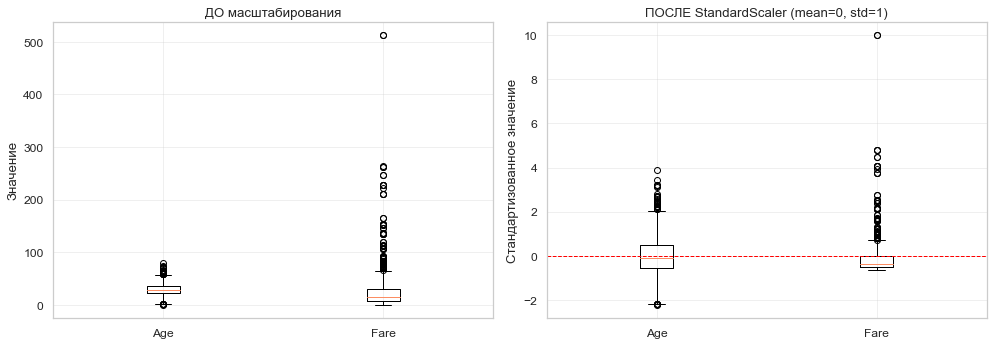


Статистика ПОСЛЕ StandardScaler:
                Age          Fare
count  7.120000e+02  7.120000e+02
mean   2.120651e-16 -1.746418e-17
std    1.000703e+00  1.000703e+00
min   -2.229476e+00 -6.625632e-01
25%   -5.727156e-01 -4.981542e-01
50%   -1.120778e-01 -3.615930e-01
75%    5.021060e-01 -1.707070e-02
max    3.880117e+00  1.000533e+01


In [13]:
from sklearn.preprocessing import StandardScaler

# Создаём и применяем StandardScaler
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)  # ТОЛЬКО transform!

# Обучаем SVM на масштабированных данных
svm_std = SVC(kernel='rbf', random_state=42)
svm_std.fit(X_train_std, y_train)
y_pred_std = svm_std.predict(X_test_std)
acc_std = accuracy_score(y_test, y_pred_std)

print(f"SVM С StandardScaler: accuracy = {acc_std:.4f}")
print(f"Улучшение: {(acc_std - acc_raw) * 100:+.1f} п.п.")

# Визуализация: распределение до и после
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# До масштабирования
axes[0].boxplot([X_train['Age'], X_train['Fare']], labels=['Age', 'Fare'])
axes[0].set_ylabel('Значение')
axes[0].set_title('ДО масштабирования')
axes[0].grid(True, alpha=0.3)

# После StandardScaler
X_train_std_df = pd.DataFrame(X_train_std, columns=X_train.columns)
axes[1].boxplot([X_train_std_df['Age'], X_train_std_df['Fare']], labels=['Age', 'Fare'])
axes[1].set_ylabel('Стандартизованное значение')
axes[1].set_title('ПОСЛЕ StandardScaler (mean=0, std=1)')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nСтатистика ПОСЛЕ StandardScaler:")
print(X_train_std_df[['Age', 'Fare']].describe())

**MinMaxScaler** для каждого значения в столбце делает следующее:

Самое маленькое значение в столбце становится 0.

Самое большое 1.

Все остальные распределяются между ними пропорционально.

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

svm_mm = SVC(kernel='rbf', random_state=42)
svm_mm.fit(X_train_mm, y_train)
y_pred_mm = svm_mm.predict(X_test_mm)
acc_mm = accuracy_score(y_test, y_pred_mm)

print(f"SVM С MinMaxScaler: accuracy = {acc_mm:.4f}")

# Сравнение
comparison = pd.DataFrame({
    'Метод': ['Без масштабирования', 'StandardScaler', 'MinMaxScaler'],
    'Accuracy': [acc_raw, acc_std, acc_mm]
})
print("\n" + "="*50)
print(comparison.to_string(index=False))
print("="*50)

SVM С MinMaxScaler: accuracy = 0.7933

               Метод  Accuracy
 Без масштабирования  0.620112
      StandardScaler  0.810056
        MinMaxScaler  0.793296


In [16]:
# Эксперимент: влияние масштабирования на разные модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM (RBF kernel)': SVC(kernel='rbf', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    # Без масштабирования
    model.fit(X_train, y_train)
    acc_raw = accuracy_score(y_test, model.predict(X_test))
    
    # С масштабированием
    model.fit(X_train_std, y_train)
    acc_scaled = accuracy_score(y_test, model.predict(X_test_std))
    
    results.append({
        'Модель': name,
        'Без масштабирования': f'{acc_raw:.3f}',
        'С масштабированием': f'{acc_scaled:.3f}',
        'Разница': f'{(acc_scaled - acc_raw):.3f}'
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print("\nВывод: Деревья НЕ требуют масштабирования (делят по порогам).")
print("SVM, Logistic Regression, kNN, нейронные сети — ТРЕБУЮТ!")

              Модель Без масштабирования С масштабированием Разница
 Logistic Regression               0.804              0.804   0.000
    SVM (RBF kernel)               0.620              0.810   0.190
       Decision Tree               0.821              0.821   0.000
       Random Forest               0.816              0.816   0.000

Вывод: Деревья НЕ требуют масштабирования (делят по порогам).
SVM, Logistic Regression, kNN, нейронные сети — ТРЕБУЮТ!


In [17]:
# НЕПРАВИЛЬНО: заполняем пропуски и масштабируем ДО split
df_wrong = df.copy()

# Удаляем ненужные столбцы
df_wrong = df_wrong.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Заполняем пропуски медианой по ВСЕМУ датасету
df_wrong['Age'].fillna(df_wrong['Age'].median(), inplace=True)
df_wrong['Embarked'].fillna(df_wrong['Embarked'].mode()[0], inplace=True)

# One-hot encoding
df_wrong = pd.get_dummies(df_wrong, columns=['Sex', 'Embarked'], drop_first=True)

# Масштабируем по ВСЕМУ датасету
scaler_wrong = StandardScaler()
X_wrong = df_wrong.drop('Survived', axis=1)
y_wrong = df_wrong['Survived']
X_wrong_scaled = scaler_wrong.fit_transform(X_wrong)

# Теперь split
X_train_wrong, X_test_wrong, y_train_wrong, y_test_wrong = train_test_split(
    X_wrong_scaled, y_wrong, test_size=0.2, stratify=y_wrong, random_state=42
)

# Обучаем
model_wrong = LogisticRegression(max_iter=1000, random_state=42)
model_wrong.fit(X_train_wrong, y_train_wrong)
acc_wrong = accuracy_score(y_test_wrong, model_wrong.predict(X_test_wrong))

print(f"❌ НЕПРАВИЛЬНО (data leakage): accuracy = {acc_wrong:.4f}")
print("\nПроблема: медиана Age и параметры StandardScaler вычислены по ВСЕМУ датасету.")
print("Тестовая выборка 'подглядела' в обучающую через эти параметры.")
print("Метрики завышены (хотя в данном случае эффект слабый из-за простоты датасета).")

❌ НЕПРАВИЛЬНО (data leakage): accuracy = 0.8045

Проблема: медиана Age и параметры StandardScaler вычислены по ВСЕМУ датасету.
Тестовая выборка 'подглядела' в обучающую через эти параметры.
Метрики завышены (хотя в данном случае эффект слабый из-за простоты датасета).


**Зачем Pipeline**

1 Автоматизация: не нужно отдельно вызывать fillna() и scale() для каждой колонки.
2 Защита от «утечки» (Data Leakage): Когда вы позже вызовете pipeline.fit(X_train), 
код вычислит медиану только на тренировочных данных. 
При предсказании на X_test он использует ту же самую тренировочную медиану.
Если считать медиану по всему датасету сразу, модель «подсмотрит» будущее, и результаты теста будут завышены.


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Подготовка данных: выделяем признаки
df_clean = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
X = df_clean.drop('Survived', axis=1)
y = df_clean['Survived']

# СНАЧАЛА разделяем  на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Определяем, какие столбцы числовые, какие категориальные
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# Создаём трансформеры для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполняем пропуски медианой
    ('scaler', StandardScaler())                    # Стандартизируем
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполняем модой
    ('onehot', OneHotEncoder(drop='first', sparse=False))  # One-hot
    # ВАЖНО: не используем handle_unknown='ignore' вместе с drop='first'
    # sklearn запрещает эту комбинацию (может создать строки из нулей)
    # На Titanic все категории известны, поэтому handle_unknown не нужен
])

# Объединяем трансформеры через ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Создаём финальный Pipeline: предобработка + модель
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Обучаем Pipeline одной командой!
pipeline.fit(X_train, y_train)

# Предсказываем
y_pred = pipeline.predict(X_test)
acc_correct = accuracy_score(y_test, y_pred)

print(f"✅ ПРАВИЛЬНО (Pipeline): accuracy = {acc_correct:.4f}")
print("\nПорядок операций (автоматический):")
print("1. fit на train → запомнить медиану Age, параметры StandardScaler, категории")
print("2. transform на train → применить сохранённые параметры")
print("3. Обучить модель на трансформированном train")
print("4. transform на test → применить ТЕ ЖЕ параметры (из train)")
print("5. Предсказать на трансформированном test")
print("\n💡 Pipeline гарантирует: test НИКОГДА не видит свои параметры!")

✅ ПРАВИЛЬНО (Pipeline): accuracy = 0.7989

Порядок операций (автоматический):
1. fit на train → запомнить медиану Age, параметры StandardScaler, категории
2. transform на train → применить сохранённые параметры
3. Обучить модель на трансформированном train
4. transform на test → применить ТЕ ЖЕ параметры (из train)
5. Предсказать на трансформированном test

💡 Pipeline гарантирует: test НИКОГДА не видит свои параметры!


In [23]:
# Извлечём трансформированные данные для визуализации
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

print("Форма данных ПОСЛЕ Pipeline:")
print(f"X_train: {X_train_transformed.shape}")
print(f"X_test:  {X_test_transformed.shape}")

# Получим имена признаков после трансформации
feature_names = (numeric_features + 
                 pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names(categorical_features).tolist())

print(f"\nПризнаки после трансформации ({len(feature_names)}):")
print(feature_names)

# Визуализация: первые 5 строк до и после
print("\n=== ДО предобработки (первые 5 строк train) ===")
print(X_train.head())

print("\n=== ПОСЛЕ предобработки (первые 5 строк train) ===")
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
print(X_train_df.head())

Форма данных ПОСЛЕ Pipeline:
X_train: (712, 9)
X_test:  (179, 9)

Признаки после трансформации (9):
['Age', 'Fare', 'SibSp', 'Parch', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S']

=== ДО предобработки (первые 5 строк train) ===
     Pclass     Sex   Age  SibSp  Parch      Fare Embarked
692       3    male   NaN      0      0   56.4958        S
481       2    male   NaN      0      0    0.0000        S
527       1    male   NaN      0      0  221.7792        S
855       3  female  18.0      0      1    9.3500        S
801       2  female  31.0      1      1   26.2500        S

=== ПОСЛЕ предобработки (первые 5 строк train) ===
        Age      Fare     SibSp     Parch  Pclass_2  Pclass_3  Sex_male  \
0 -0.081135  0.513812 -0.465084 -0.466183       0.0       1.0       1.0   
1 -0.081135 -0.662563 -0.465084 -0.466183       1.0       0.0       1.0   
2 -0.081135  3.955399 -0.465084 -0.466183       0.0       0.0       1.0   
3 -0.887827 -0.467874 -0.465084  0.727782      

In [24]:
# Попробуем разные модели в том же Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('SVM (RBF)', SVC(kernel='rbf', random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

results = []
for name, clf in classifiers:
    # Создаём новый Pipeline с текущим классификатором
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Обучаем и оцениваем
    pipe.fit(X_train, y_train)
    acc = accuracy_score(y_test, pipe.predict(X_test))
    
    results.append({'Модель': name, 'Accuracy': acc})

results_df = pd.DataFrame(results)
print("Сравнение моделей в Pipeline:")
print(results_df.to_string(index=False))

Сравнение моделей в Pipeline:
              Модель  Accuracy
 Logistic Regression  0.798883
           SVM (RBF)  0.826816
       Random Forest  0.798883


In [25]:
from sklearn.model_selection import cross_val_score

# 5-fold CV на всём датасете (Pipeline сам разделит правильно)
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print("5-Fold Cross-Validation с Pipeline:")
print(f"Scores по фолдам: {cv_scores}")
print(f"Средний accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("\n💡 Pipeline + CV = идеальная комбинация:")
print("   Каждый фолд обрабатывается независимо, без data leakage!")

5-Fold Cross-Validation с Pipeline:
Scores по фолдам: [0.78212291 0.80898876 0.78651685 0.76966292 0.83707865]
Средний accuracy: 0.7969 ± 0.0238

💡 Pipeline + CV = идеальная комбинация:
   Каждый фолд обрабатывается независимо, без data leakage!


In [44]:
import joblib

# Обучаем на всех данных для финального предсказания
pipeline.fit(X, y)

# Сохраняем Pipeline
joblib.dump(pipeline, 'titanic_pipeline.pkl')
print("Pipeline сохранён в 'titanic_pipeline.pkl'")

# Пример использования сохранённого Pipeline
loaded_pipeline = joblib.load('titanic_pipeline.pkl')

# Предсказание для нового пассажира
new_passenger = pd.DataFrame({
    'Pclass': [3],
    'Sex': ['male'],
    'Age': [25],
    'SibSp': [0],
    'Parch': [0],
    'Fare': [7.25],
    'Embarked': ['S']
})

prediction = loaded_pipeline.predict(new_passenger)
probability = loaded_pipeline.predict_proba(new_passenger)[0]

print(f"\nНовый пассажир: мужчина 25 лет, 3 класс, один, билет $7.25, порт S")
print(f"Предсказание: {'Выжил' if prediction[0] == 1 else 'Погиб'}")
print(f"Вероятность выживания: {probability[1]:.1%}")

Pipeline сохранён в 'titanic_pipeline.pkl'

Новый пассажир: мужчина 25 лет, 3 класс, один, билет $7.25, порт S
Предсказание: Погиб
Вероятность выживания: 10.9%
